<a href="https://colab.research.google.com/github/jeeberhardt/mobius/blob/colab/examples/Would_BO_have_helped_me/Would_Bayesian_optimization_have_helped_me%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Would Bayesian optimization have helped me?

You might be wondering if Bayesian Optimization (BO) would have helped you with your peptide design/optimization project. Now's your chance to find out by trying it out retrospectively on existing data sitting on your hard drive.

This Colab notebook provides the essential tools to get it started. For more advanced applications, such as integrating BO with other tools like docking software, protein design tools (e.g., Rosetta or AF2), or customizing peptide optimization with different molecular representations (like language models or Graph Neural Networks), you can refer to the [mobius documentation](https://mobius.readthedocs.io/en/master/) or have a look at the couple of [examples](https://git.scicore.unibas.ch/schwede/mobius/-/tree/master/examples).

The process is straightforward:
- You begin by selecting a subset of peptides from your existing dataset, either randomly, or by choosing the worst peptides based on experimental values (scores), or based on your own selection. This subset is what I am calling the "seed library".
- The BO method will then select the most promising candidates from your dataset based on the information from the seed library, then retrieve their actual experimental values (scores) from your dataset, and repeat the process by incorporating the new data. This cycle continues for N iterations or until no data remains.

This retrospective analysis allows you to see how BO might have influenced your experimental outcomes and may give you insights into how to approach future projects more effectively. And if this experiment proves conclusive, who knows you might even consider incorporating BO in your future experiments!

By the way, you can also use that Colab notebook for small molecules.

## Installation

In [ ]:
#@title Execute this cell to install conda. After the installation, it will restart the kernel.
! pip install -q condacolab

import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


In [1]:
#@title Then execute this cell to install the Mobius package. This might take a couple of minutes...
import condacolab
condacolab.check()

! git clone https://git.scicore.unibas.ch/schwede/mobius.git
! cd mobius; mamba env update -n base -f environment.yaml
! cd mobius; pip install -e . --no-deps
# ! mamba install pytorch-scatter==2.1.2 -c conda-forge -c pyg

Streaming output truncated to the last 5000 lines.
[+] 7.2s
Extracting  (32)  ⣾  msgpack-python                                      96.8kB @  13.4kB/s  0.1s
[+] 7.3s
Extracting  (32)  ⣾  unicodedata2                                       374.1kB @  51.1kB/s  0.2s
kiwisolver                                          73.1kB @  10.0kB/s  0.1s
markupsafe                                          24.5kB @   3.3kB/s  0.1s
[+] 7.4s
Extracting  (34)  ⣾  cairo                                              984.2kB @ 132.2kB/s  0.1s
llvmlite                                             3.4MB @ 451.6kB/s  0.2s
[+] 7.5s
Extracting  (36)  ⣾  libcblas                                            12.8kB @   1.7kB/s  0.1s
fonttools                                            2.4MB @ 311.9kB/s  0.1s
[+] 7.6s
Extracting  (38)  ⣾  [+] 7.7s
Extracting  (37)  ⣾  pango                                              448.5kB @  57.7kB/s  0.2s
[+] 7.8s
Extracting  (38)  ⣾  [+] 7.9s
Extracting  (38)  ⣾  biopython       

## Bayesian Optimization (BO)

## Input peptide dataset

The input csv file must contains at least the following columns:
- peptide: the peptide column contains the peptide sequence, either in SMILES or FASTA format.
- score: the score column contains the experimental values for each peptide sequence.
- seed_library (optional): The seed_library contains boolean values. True if peptide is part of the seed library or False if not.

You do not have data yet, but still want to try it out? You can use this peptide permeability dataset: [CycPeptMPDB_Peptide_Dataset](https://)

In [2]:
import io

import pandas as pd
import numpy as np
from google.colab import files

#@markdown ###Specify the input format (SMILES, FASTA) (Mobius supports also HELM strings!)
input_type = "SMILES" # @param ["SMILES","FASTA"]
#@markdown ###Specify how to initialize the seed library
#@markdown Options: Worst (select worst peptide based on score), Random (select peptide randomly), User defined (select peptides based on seed_library column, True or False)
initialization_strategy = 'Worst' #@param ['Worst', 'Random', 'User defined'] {type:"string"}
#@markdown ###Specify the number of peptides for the seed library (only for Worst or Random)
initialization_size = 96 #@param {type:"raw"}
#@markdown ###About the score: is the lower the better or the higher the better? (only for Worst or Random)
which_is_better = 'Higher' #@param ['Lower', 'Higher'] {type:"string"}

assert initialization_size > 0, 'The initialization size must be greater than 0.'

uploaded = files.upload()

dataset = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

assert 'peptide' in dataset.columns, 'Error: Could not find peptide column in dataset.'
assert 'score' in dataset.columns, 'Error: Could not find score column in dataset.'

if initialization_strategy == 'Worst':
  if which_is_better == 'Lower':
    # Put the lowest scores at the bottom
    ascending = False
  else:
    # Put the highest scores at the bottom
    ascending = True

  dataset = dataset.sort_values(by='score', ascending=ascending)

  seed_library = dataset['peptide'][:initialization_size].values
  scores_seed_library = dataset['score'][:initialization_size].values
elif initialization_strategy == 'Random':
  idx = np.random.choice(dataset.index, size=initialization_size)
  seed_library = dataset['peptide'].values[idx]
  scores_seed_library = dataset['score'].values[idx]
else:
  assert 'seed_library' in dataset.columns, 'Error: Could not find seed_library column in dataset.'

  seed_library = dataset[dataset['seed_library'] == True]['peptide'].values
  scores_seed_library = dataset[dataset['seed_library'] == True]['score'].values

print('')
print(f'The full dataset contains {len(dataset)} peptides.')
print(f'The seed library contains {len(seed_library)} peptides, with scores from {np.min(scores_seed_library):.3f} to {np.max(scores_seed_library):.3f}.')


Saving CycPeptMPDB_Peptide_Dataset.csv to CycPeptMPDB_Peptide_Dataset.csv

The full dataset contains 7092 peptides.
The seed library contains 96 peptides, with scores from -9.460 to -8.000.


In [3]:
#@title Configure Bayesian optimization

#@markdown ###Specify the input featurizer (MAP4, MAP4C, Graph kernel or GIN)
featurizer = 'Graph kernel (WL)' #@param ['MAP4', 'MAP4C', 'Graph kernel (WL)', 'GNN (GIN)'] {type:"string"}
#@markdown ###Specify the number of DMT cycles (from 1 to 5)
n_iterations = 5 #@param [1, 2, 3, 4, 5] {type:"raw"}
#@markdown ###Specify the number of peptides "tested" per batch
batch_size = 96 #@param {type:"raw"}
#@markdown ###Specify if you want to maximize or minimize the score (Minimize or Maximize)
objective = 'Maximize' #@param ['Maximize', 'Minimize'] {type:"string"}

assert batch_size > 0, 'The batch size must be greater than 0.'

if objective == 'Maximize':
  maximize = True
else:
  maximize = False


In [4]:
#@title Run Bayesian optimization!

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from rdkit import Chem
from grakel.kernels import WeisfeilerLehman
from gpytorch.kernels import RBFKernel
from gpytorch.priors import NormalPrior
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN, GAT, GCN, GraphSAGE

from mobius.mobius import ExpectedImprovement, Pool, Planner
from mobius.mobius import GPGKModel, GPModel, GPGNNModel
from mobius.mobius import Graph, Map4Fingerprint
from mobius.mobius import TanimotoSimilarityKernel


class GNNModel(torch.nn.Module):
    def __init__(self, model_name, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        models = {'GIN': GIN, 'GAT': GAT, 'GCN': GCN, 'GraphSAGE': GraphSAGE}
        gnn_model = models[model_name]

        self.model = gnn_model(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers,
                               out_channels=out_channels, dropout=dropout)

        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x


if featurizer == 'MAP4':
  map4 = Map4Fingerprint(input_type=input_type, chiral=False)
  gpmodel = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))
elif featurizer == 'MAP4C':
  map4 = Map4Fingerprint(input_type=input_type, chiral=True)
  gpmodel = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))
elif featurizer == 'Graph kernel (WL)':
  graph_convertor = Graph(input_type=input_type, output_type='grakel')
  kernel = WeisfeilerLehman(normalize=True, n_iter=5)
  gpmodel = GPGKModel(kernel=kernel, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))
else:
  graph_convertor = Graph(input_type=input_type, output_type='pyg')
  graphs = graph_convertor.transform(dataset['peptide'].values[0])
  gnn = GNNModel('GIN', in_channels=graphs.node_attr.shape[1], hidden_channels=256, out_channels=256, num_layers=4, dropout=0.25)
  gpmodel = GPGNNModel(kernel=RBFKernel(ard_num_dims=256, eps=1e-2), model=gnn, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

acq = ExpectedImprovement(gpmodel, maximize=maximize)
optimizer = Pool(dataset['peptide'].values, batch_size=1000)
ps = Planner(acq, optimizer)

peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(featurizer, 0, p, s) for p, s in zip(peptides, scores)]

for i in range(n_iterations):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=batch_size)

    # Get real scores
    scores_suggested_peptides = [dataset[dataset['peptide'] == p]['score'].values[0] for p in suggested_peptides]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(featurizer, i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    if maximize:
      best_seq = peptides[np.argmax(scores)]
      best_scores = np.max(scores)
    else:
      best_seq = peptides[np.argmin(scores)]
      best_scores = np.min(scores)

    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

    # Save results after each iteration, just to be sure...
    df = pd.DataFrame(data=data, columns=('model', 'iter', 'peptide', 'exp_score'))
    df.to_csv('results_optimization.csv', index=False)


Fitting GPGK model (cpu): 20step [00:17,  1.17step/s, loss=0.497]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C(=O)[C@H](CCCC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.300



Fitting GPGK model (cpu): 17step [00:21,  1.24s/step, loss=1.17]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 20step [00:39,  1.97s/step, loss=1.2]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 17step [00:45,  2.67s/step, loss=1.12]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



Fitting GPGK model (cpu): 16step [00:55,  3.49s/step, loss=1.1]


Best peptide: CCCC[C@@H]1NC(=O)[C@H](CCCC)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H](CCCC)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)CSC[C@@H](C(=O)NC)NC(=O)[C@H](CCCC)N(C)C1=O / -4.000



In [5]:
#@title Run a random search (for benchmark purpose)

#@markdown The goal here is to see if can do better than a random search.

peptides = seed_library.copy()
scores = scores_seed_library.copy()

data = [('random', 0, p, s) for p, s in zip(peptides, scores)]

pool = dataset[~dataset['peptide'].isin(peptides)].copy()

for i in range(n_iterations):
    suggested_peptides = np.random.choice(dataset['peptide'], size=batch_size, replace=False)
    scores_suggested_peptides = [dataset[dataset['peptide'] == p]['score'].values[0] for p in suggested_peptides]

    pool = pool[~pool['peptide'].isin(suggested_peptides)].copy()

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('random', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    if maximize:
      best_seq = peptides[np.argmax(scores)]
      best_scores = np.max(scores)
    else:
      best_seq = peptides[np.argmin(scores)]
      best_scores = np.min(scores)

    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'peptide', 'exp_score'))
df.to_csv('results_optimization_random.csv', index=False)


Best peptide: CC[C@H](C)[C@H]1C(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N2CCCCC2)Cc2cccc(c2)CCCCC(=O)N[C@@H]([C@@H](C)O)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](CC(C)C)C(=O)NCC(=O)N1C / -4.190

Best peptide: CC[C@H](C)[C@H]1C(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N2CCCCC2)Cc2cccc(c2)CCCCC(=O)N[C@@H]([C@@H](C)O)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](Cc2ccccc2)C(=O)N(C)[C@@H](CC(C)C)C(=O)NCC(=O)N1C / -4.190

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H]2CCCN2C(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@@H](C)NC(=O)[C@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O / -4.000

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H]2CCCN2C(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@@H](C)NC(=O)[C@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O / -4.000

Best peptide: CC(C)C[C@@H]1NC(=O)[C@H]2CCCN2C(=O)[C@@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@@H](C)NC(=O)[C@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O / -4.000



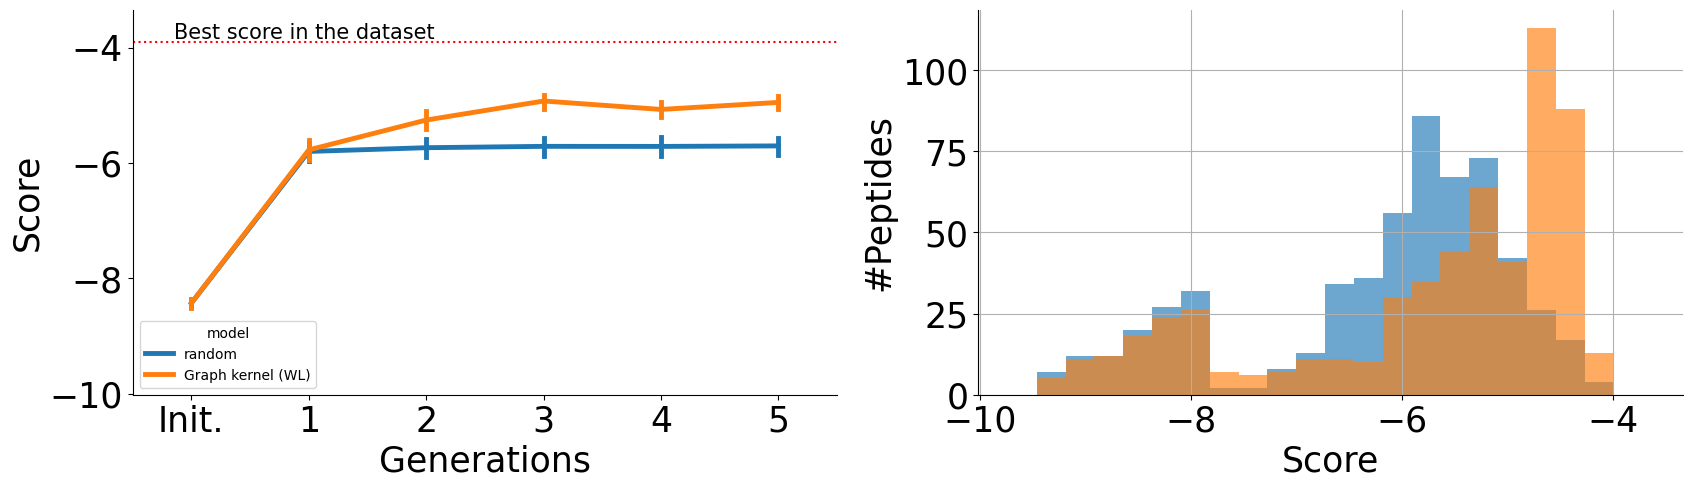

In [6]:
#@title Plot the resuts

df_random = pd.read_csv('results_optimization_random.csv')
df = pd.read_csv('results_optimization.csv')
df = pd.concat([df_random, df])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_score
d = {0: 'Init.'}
d.update({n: str(n) for n in range(1, n_iterations + 1)})
df['iter'] = df['iter'].replace(d)

sns.lineplot(x='iter', y='exp_score', hue='model', data=df, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

if which_is_better == 'Lower':
  ax[0].axhline(y=dataset['score'].min(), color='red', linestyle=':')
  y = dataset['score'].min() + ((dataset['score'].max() - dataset['score'].min()) * 0.01)
  ax[0].text(-0.15, y, 'Best score in the dataset', fontsize=15)
else:
  ax[0].axhline(y=dataset['score'].max(), color='red', linestyle=':')
  y = dataset['score'].max() + ((dataset['score'].max() - dataset['score'].min()) * 0.01)
  ax[0].text(-0.15, y, 'Best score in the dataset', fontsize=15)

ymin = dataset['score'].min() - ((dataset['score'].max() - dataset['score'].min()) * 0.10)
ymax = dataset['score'].max() + ((dataset['score'].max() - dataset['score'].min()) * 0.10)

ax[0].set_xlim([-0.5, n_iterations + 0.5])
ax[0].set_ylim([ymin, ymax])
ax[0].set_ylabel('Score', fontsize=25)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_score'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == featurizer]['exp_score'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([ymin, ymax])
ax[1].set_xlabel('Score', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()

plt.savefig('figure_results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
